### TASK 1

In [1362]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [1363]:
def load_dataset(split_ratio=0.5):
    # Read in the .csv file and split train test
    data_frame = pd.read_csv('Mixcancer.csv')
    data = data_frame.to_numpy()

    # Strip off the diagnostic column to get the features
    x = data[:, 1:]
    x = MinMaxScaler().fit_transform(x)

    # This column becomes the y
    y = data[:, 0]
    y = y.reshape(len(y), 1)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_ratio, shuffle=True)
    return x_train, y_train, x_test, y_test

Define activation and loss functions for use in the model

In [1364]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x)*(1.0-sigmoid(x))


def reLu(x):
    return np.maximum(x, 0)


def reLu_der(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x


def cross_entropy(x, y):
    return (-y*(np.log(x)) - (1-y) * np.log(1-x))


def cross_entropy_derivative(x, y):
    return -(y/x - (1-y)/(1-x))


In [1365]:

class ANN:
    def __init__(self, batch_size, learning_rate, epochs):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, x_train, y_train, x_test, y_test):
        # Initialize weights and bias
        neuron_count_l1 = 30
        neuron_count_l2 = 1

        self.w1 = np.random.uniform(-1, 1, (x_train.shape[1], neuron_count_l1))
        self.b1 = np.zeros((1, neuron_count_l1))
        self.w2 = np.random.uniform(-1, 1, (neuron_count_l1, neuron_count_l2))
        self.b2 = np.zeros((1, neuron_count_l2))

        epoch_train_error = []
        epoch_train_accuracy = []
        epoch_test_error = []
        epoch_test_accuracy = []

        last_error = 999
        for _ in range(self.epochs):
            # Mini batches data shuffled on each epoch
            random_x_train_indices = np.arange(x_train.shape[0])
            np.random.shuffle(random_x_train_indices)

            # For each mini batch
            mini_batch_train_errors = []
            mini_batch_train_accuracies = []

            mini_batch_test_errors = []
            mini_batch_test_accuracies = []

            for i in range(0, random_x_train_indices.shape[0], self.batch_size):
                # Test feed forward (confirm network is training correctly)
                in_1 = x_test@self.w1 + self.b1
                out_1 = sigmoid(in_1)
                in_2 = out_1@self.w2 + self.b2
                out_2 = sigmoid(in_2)

                test_error = cross_entropy(out_2, y_test).mean()
                test_pred = np.where(out_2 > 0.5, 1, 0)
                test_accuracy = accuracy_score(y_test, test_pred)

                mini_batch_test_errors.append(test_error)
                mini_batch_test_accuracies.append(test_accuracy)

                # Train feed forward
                x_batch = x_train[i:i + self.batch_size]
                y_batch = y_train[i:i + self.batch_size]

                in_1 = x_batch@self.w1 + self.b1
                out_1 = sigmoid(in_1)
                in_2 = out_1@self.w2 + self.b2
                out_2 = sigmoid(in_2)

                train_error = cross_entropy(out_2, y_batch).mean()

                train_pred = np.where(out_2 > 0.5, 1, 0)
                train_accuracy = accuracy_score(y_batch, train_pred)

                mini_batch_train_errors.append(train_error)
                mini_batch_train_accuracies.append(train_accuracy)

                # Backpropagate using only the training data
                # Layer 2
                dE_dO2 = cross_entropy_derivative(out_2, y_batch)
                dO2_dIn2 = sigmoid_derivative(in_2)
                dIn2_dW2 = out_1
                dE_dW2 = (1/x_batch.shape[0])*dIn2_dW2.T@(dE_dO2*dO2_dIn2)
                dE_dB2 = (1/x_batch.shape[0]) * \
                    np.ones([1, len(x_batch)])@(dE_dO2*dO2_dIn2)

                # Layer 1
                dIn2_dO1 = self.w2
                dO1_dIn1 = sigmoid_derivative(in_1)
                dIn1_dW1 = x_batch
                dE_dW1 = (
                    1/x_batch.shape[0])*dIn1_dW1.T@((dE_dO2*dO2_dIn2@dIn2_dO1.T)*dO1_dIn1)
                dE_dB1 = (1/x_batch.shape[0])*np.ones([len(x_batch)]
                                                      )@((dE_dO2*dO2_dIn2@dIn2_dO1.T)*dO1_dIn1)

                # Updating parameters
                self.b2 -= self.learning_rate * dE_dB2
                self.w2 -= self.learning_rate * dE_dW2
                self.b1 -= self.learning_rate * dE_dB1
                self.w1 -= self.learning_rate * dE_dW1

            #Adaptive learning rate
            # average_training_error = np.mean(mini_batch_train_errors)
            
            # if average_training_error > last_error:
            #     self.learning_rate -= self.learning_rate * 0.1
            
            # last_error = average_training_error

            # Average the error and acuracy across the 2 batches
            epoch_train_error.append(np.mean(mini_batch_train_errors))
            epoch_train_accuracy.append(np.mean(mini_batch_train_accuracies))

            epoch_test_error.append(np.mean(mini_batch_test_errors))
            epoch_test_accuracy.append(np.mean(mini_batch_test_accuracies))

        # Plot loss for training and test
        z = np.arange(self.epochs)
        plt.figure(1)
        plt.plot(z, epoch_train_error, label="train")
        plt.plot(z, epoch_test_error, label="test")
        plt.xlabel('Epochs')
        plt.ylabel('Cross Entropy Loss')
        plt.legend(loc='best')
        plt.title('Loss')

        # Plot accuracy for training and test
        plt.figure(2)
        plt.plot(z, epoch_train_accuracy, label="train")
        plt.plot(z, epoch_test_accuracy, label="test")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
        plt.title('Accuracy')

    def score(self, x_test, y_test):
        in_l1 = x_test@self.w1 + self.b1
        out_l1 = sigmoid(in_l1)
        in_l2 = out_l1@self.w2 + self.b2
        out_l2 = sigmoid(in_l2)

        pred = np.where(out_l2 > 0.5, 1, 0)
        
        accuracy = accuracy_score(y_test, pred)
        average_loss = cross_entropy(out_l2, y_test).mean()
        f1 = f1_score(y_test, pred)

        print("Final Test Accuracy: {:.2f}".format(accuracy))
        print("Final Test Loss: {:.2f}".format(average_loss))
        print("Final F Measure: {:.2f}".format(f1))


Final Test Accuracy: 0.96
Final Test Loss: 0.15
Final F Measure: 0.97


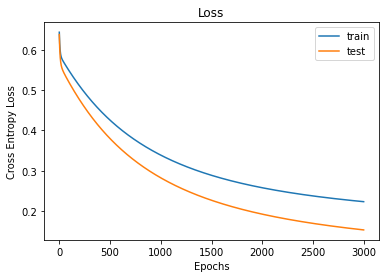

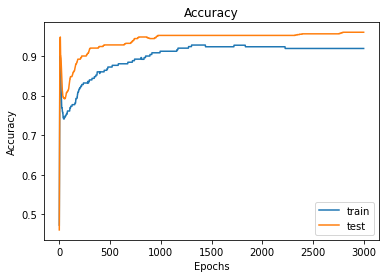

In [1366]:
def main():
    x_train, y_train, x_test, y_test = load_dataset(split_ratio=0.5)

    ann = ANN(batch_size=64, learning_rate=0.006, epochs=3000)

    ann.train(x_train, y_train, x_test, y_test)

    ann.score(x_test, y_test)
main()